In [1]:
import warnings
import scanpy as sc
import decoupler as dc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
#os.makedirs('results', exist_ok=True)

In [3]:
dir_path = '../data/filtered_adata/'

In [4]:
os.listdir(dir_path)

['chimp.h5ad',
 'human.h5ad',
 'macaque.h5ad',
 'macaque_new.h5ad',
 'spatial_libd_human.h5ad']

#  Calculate pseudobulks

## Calculate for each specie

In [9]:
adata_dict = dict()
mode = 'mean'
for file_name in tqdm(os.listdir(dir_path)):
    file = file_name.split('.')[0]
    # read visium data
    adata = sc.read_h5ad(dir_path + file_name)
    adata.obs_names_make_unique()
    adata.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
    adata.obs['condition'] = file
    adata_dict[file] = adata
    # calculate pseudobulks
    pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_id',
    groups_col='label',
    mode=mode,
    min_cells=0,
    min_counts=0
    )
    # save files
    #pdata.obs['condition'] = file
    pdata.obs['condition'] = file
    pdata.obs = pdata.obs[['label', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']]
    pdata.obs.columns = ['layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']
    #pdata.write_h5ad(f'results/pb_{file}.h5ad')

  0%|          | 0/5 [00:00<?, ?it/s]

c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique

## Calculate for mammals

In [12]:
# Concat adata objects
adata = an.concat([adata_dict['human'], adata_dict['chimp'], adata_dict['macaque']] , merge='same',uns_merge="unique")

# Make pseudobulk
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_id',
    groups_col='label',
    mode=mode,
    min_cells=0,
    min_counts=0
    )

pdata.obs = pdata.obs[['label', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']]
pdata.obs.columns = ['layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']
pdata

c:\projects\spatialMPFC\venv\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [13]:
pdata.write_h5ad(f'../data/pseudobulks/pb_mammals.h5ad')

## Calculate for humans (old and young)

In [8]:
# Concat adata objects
adata = an.concat([adata_dict['human'], adata_dict['spatial_libd_human']] , merge='same',uns_merge="unique")

# Make pseudobulk
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample_id',
    groups_col='label',
    mode=mode,
    min_cells=0,
    min_counts=0
    )

pdata.obs = pdata.obs[['label', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']]
pdata.obs.columns = ['layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition']
pdata

d:\projects\diploma\venv_stats2\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 111 × 17919
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [9]:
pdata.write_h5ad(f'results/pb_age.h5ad')

In [10]:
del pdata, adata, adata_dict

# Visualization

## Mammals

In [23]:
adata_pb = sc.read_h5ad('results/pb_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [24]:
# calculate library size
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["psbulk_counts"])

### Counts

Let's look at raw pseudobulks

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


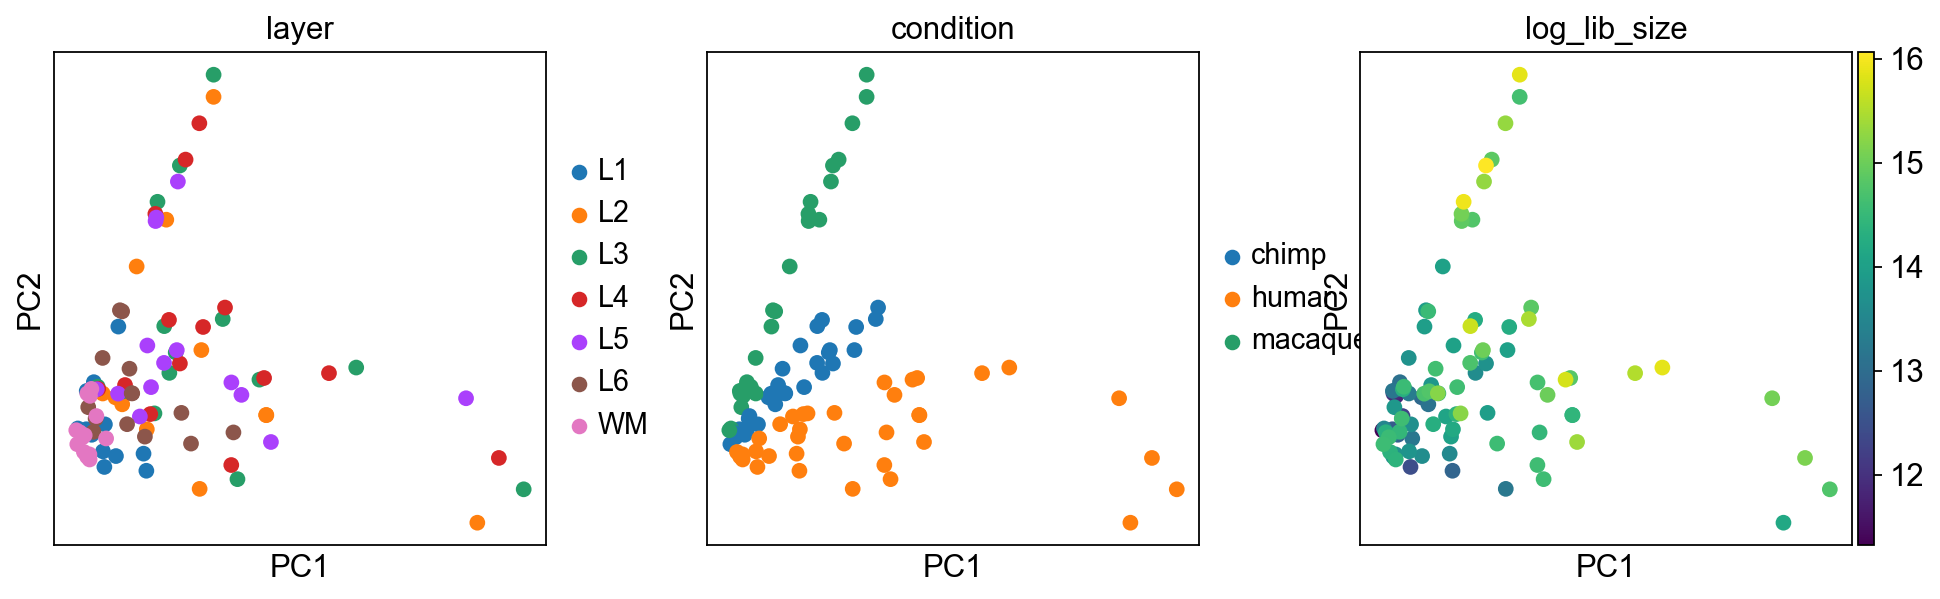

In [25]:
sc.pp.pca(adata_pb)
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/3 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)
computing PCA
    with n_comps=30
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


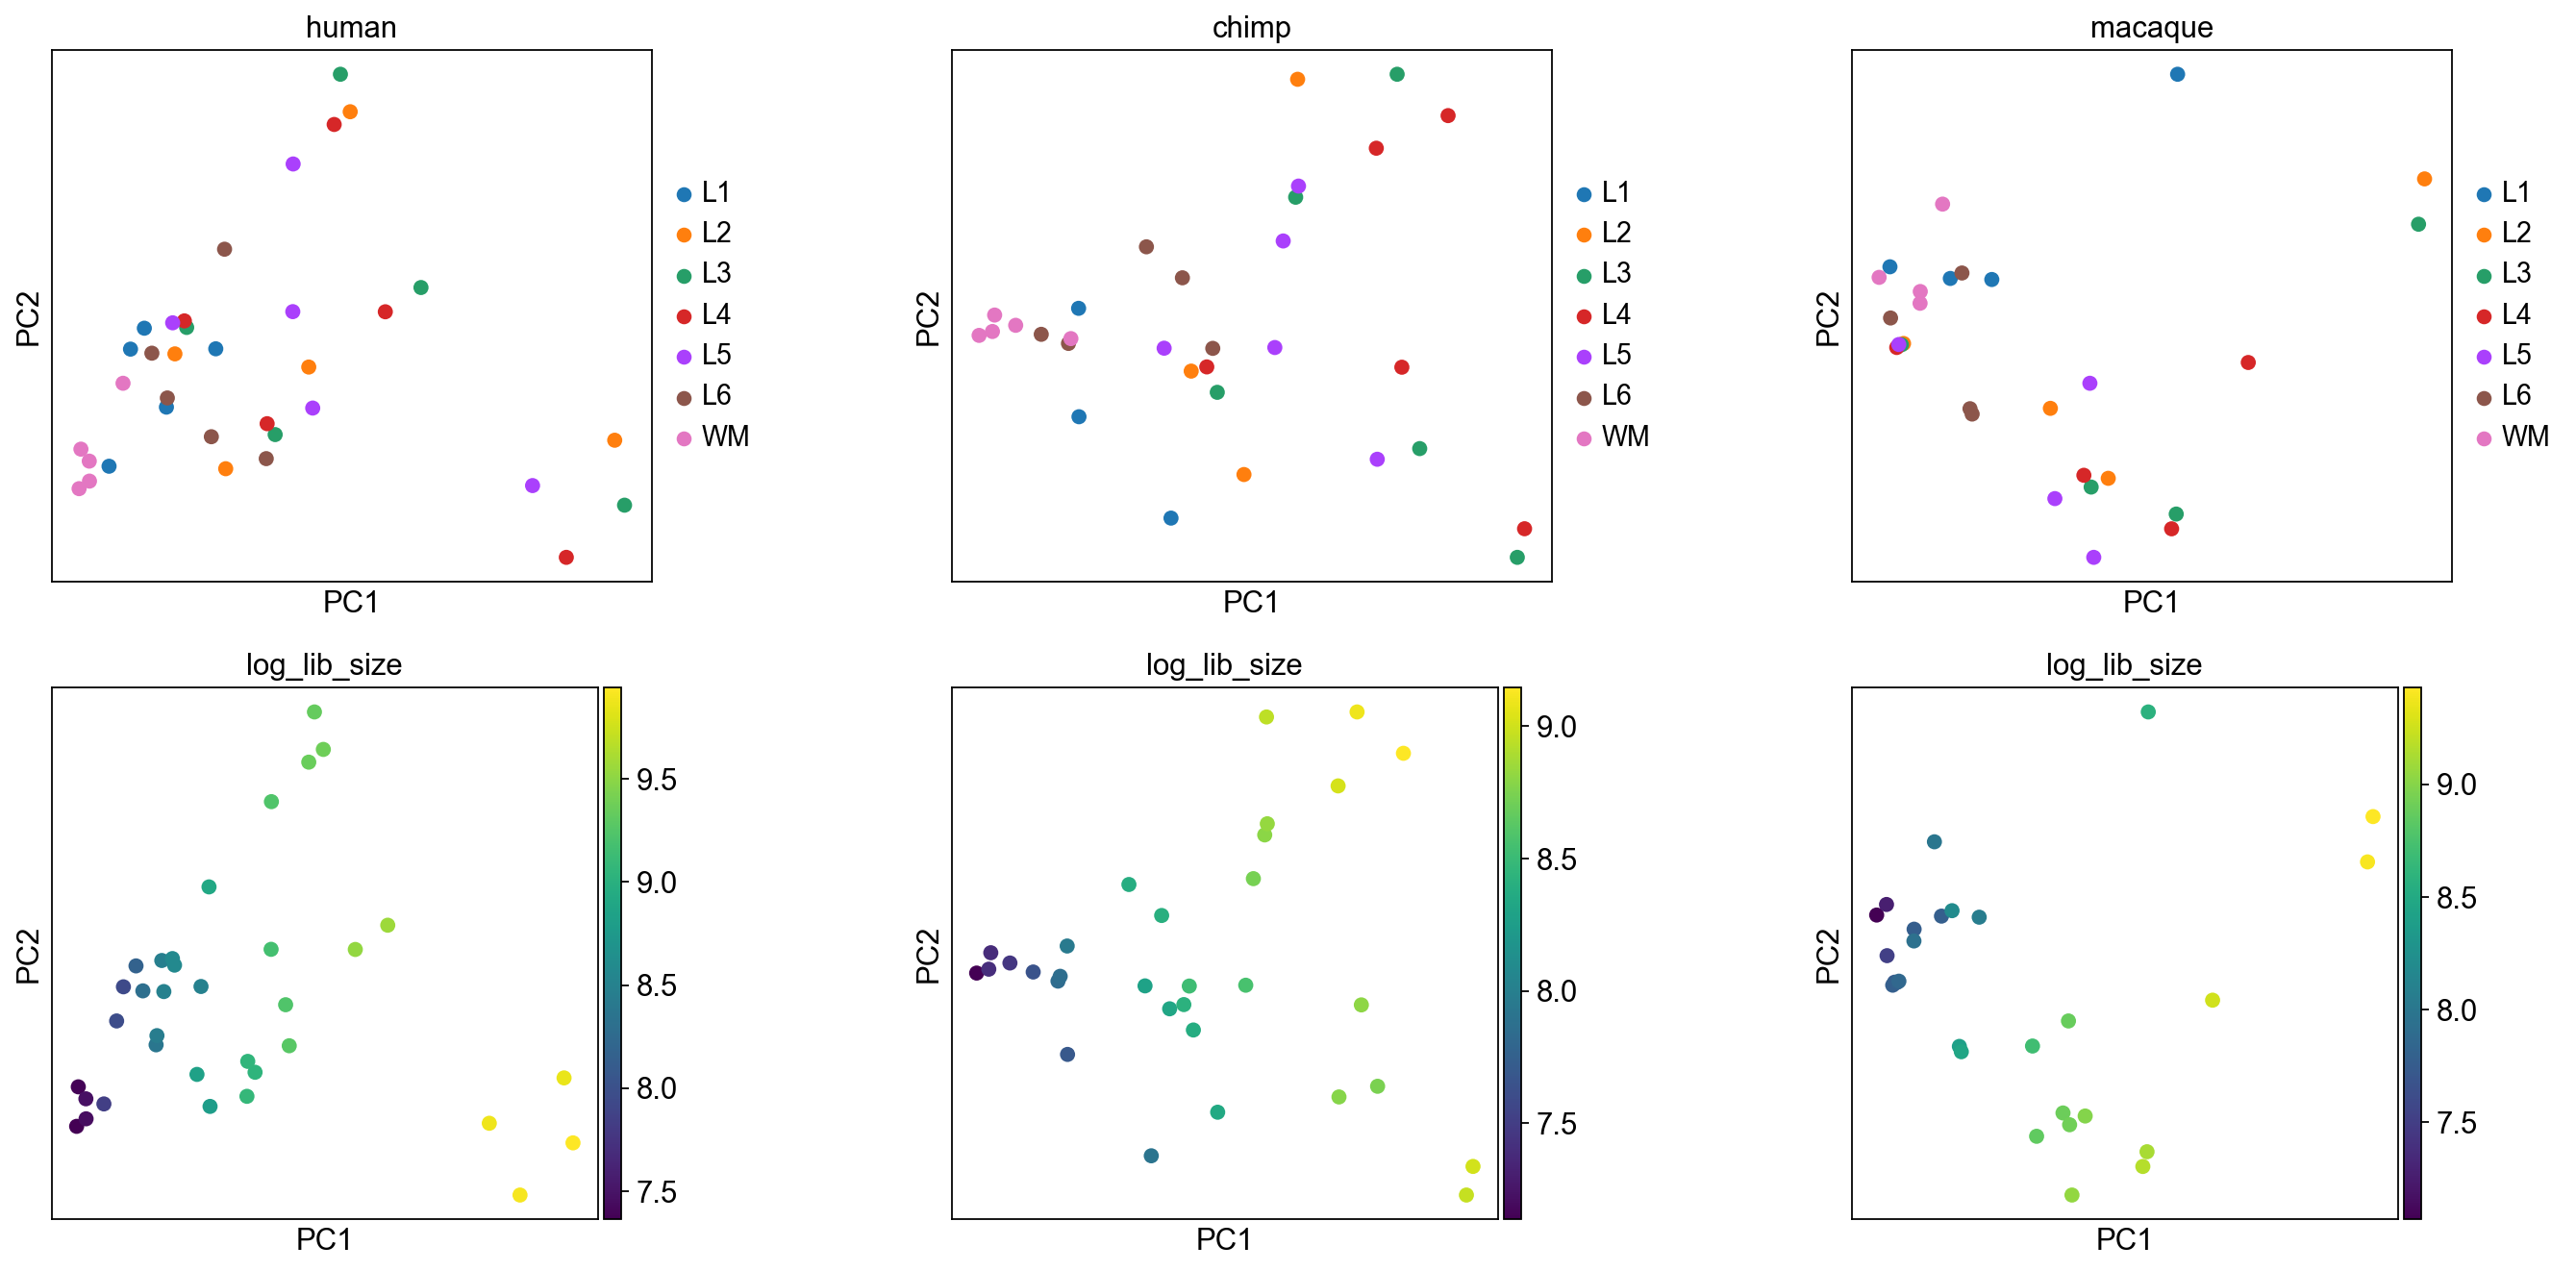

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), gridspec_kw={'wspace': 0.5})
conditions = ['human', 'chimp', 'macaque']

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = sc.read_h5ad(f'results/pb_{condition}.h5ad')
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # calculate pca
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)

### Log(CPM)

Визуализируем псевдобалки нормализованые на глубину библиотеки

In [27]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


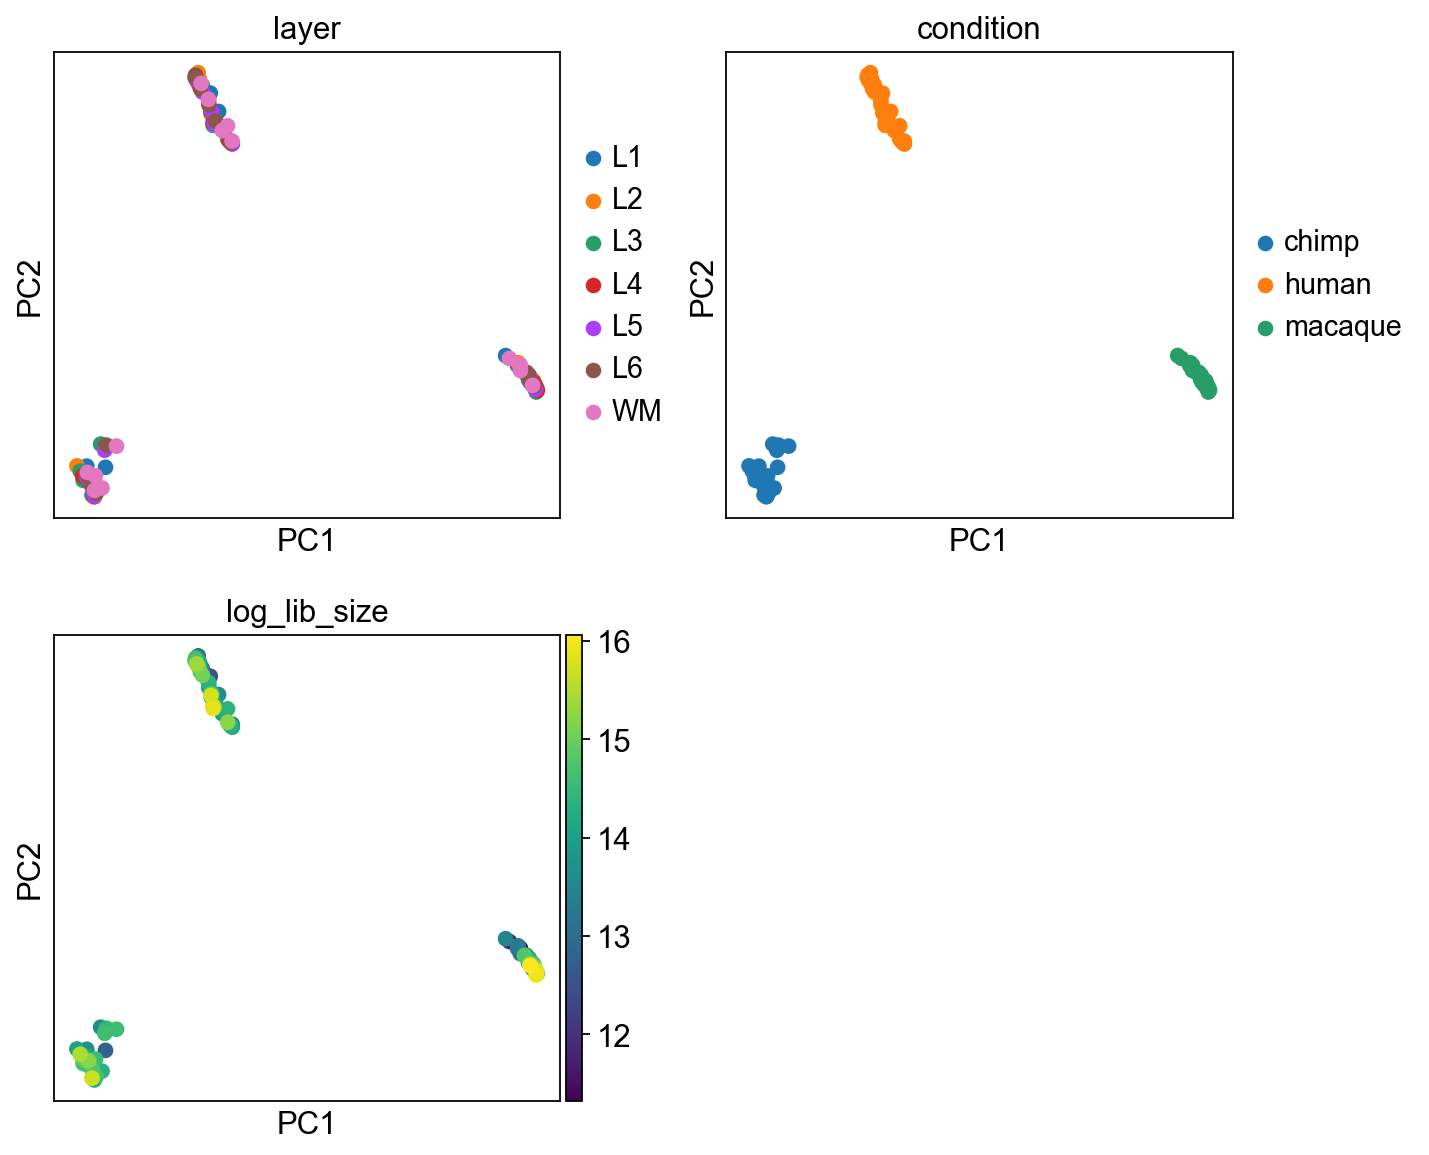

In [28]:
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=2)

  0%|          | 0/3 [00:00<?, ?it/s]

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=34
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=30


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=27
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


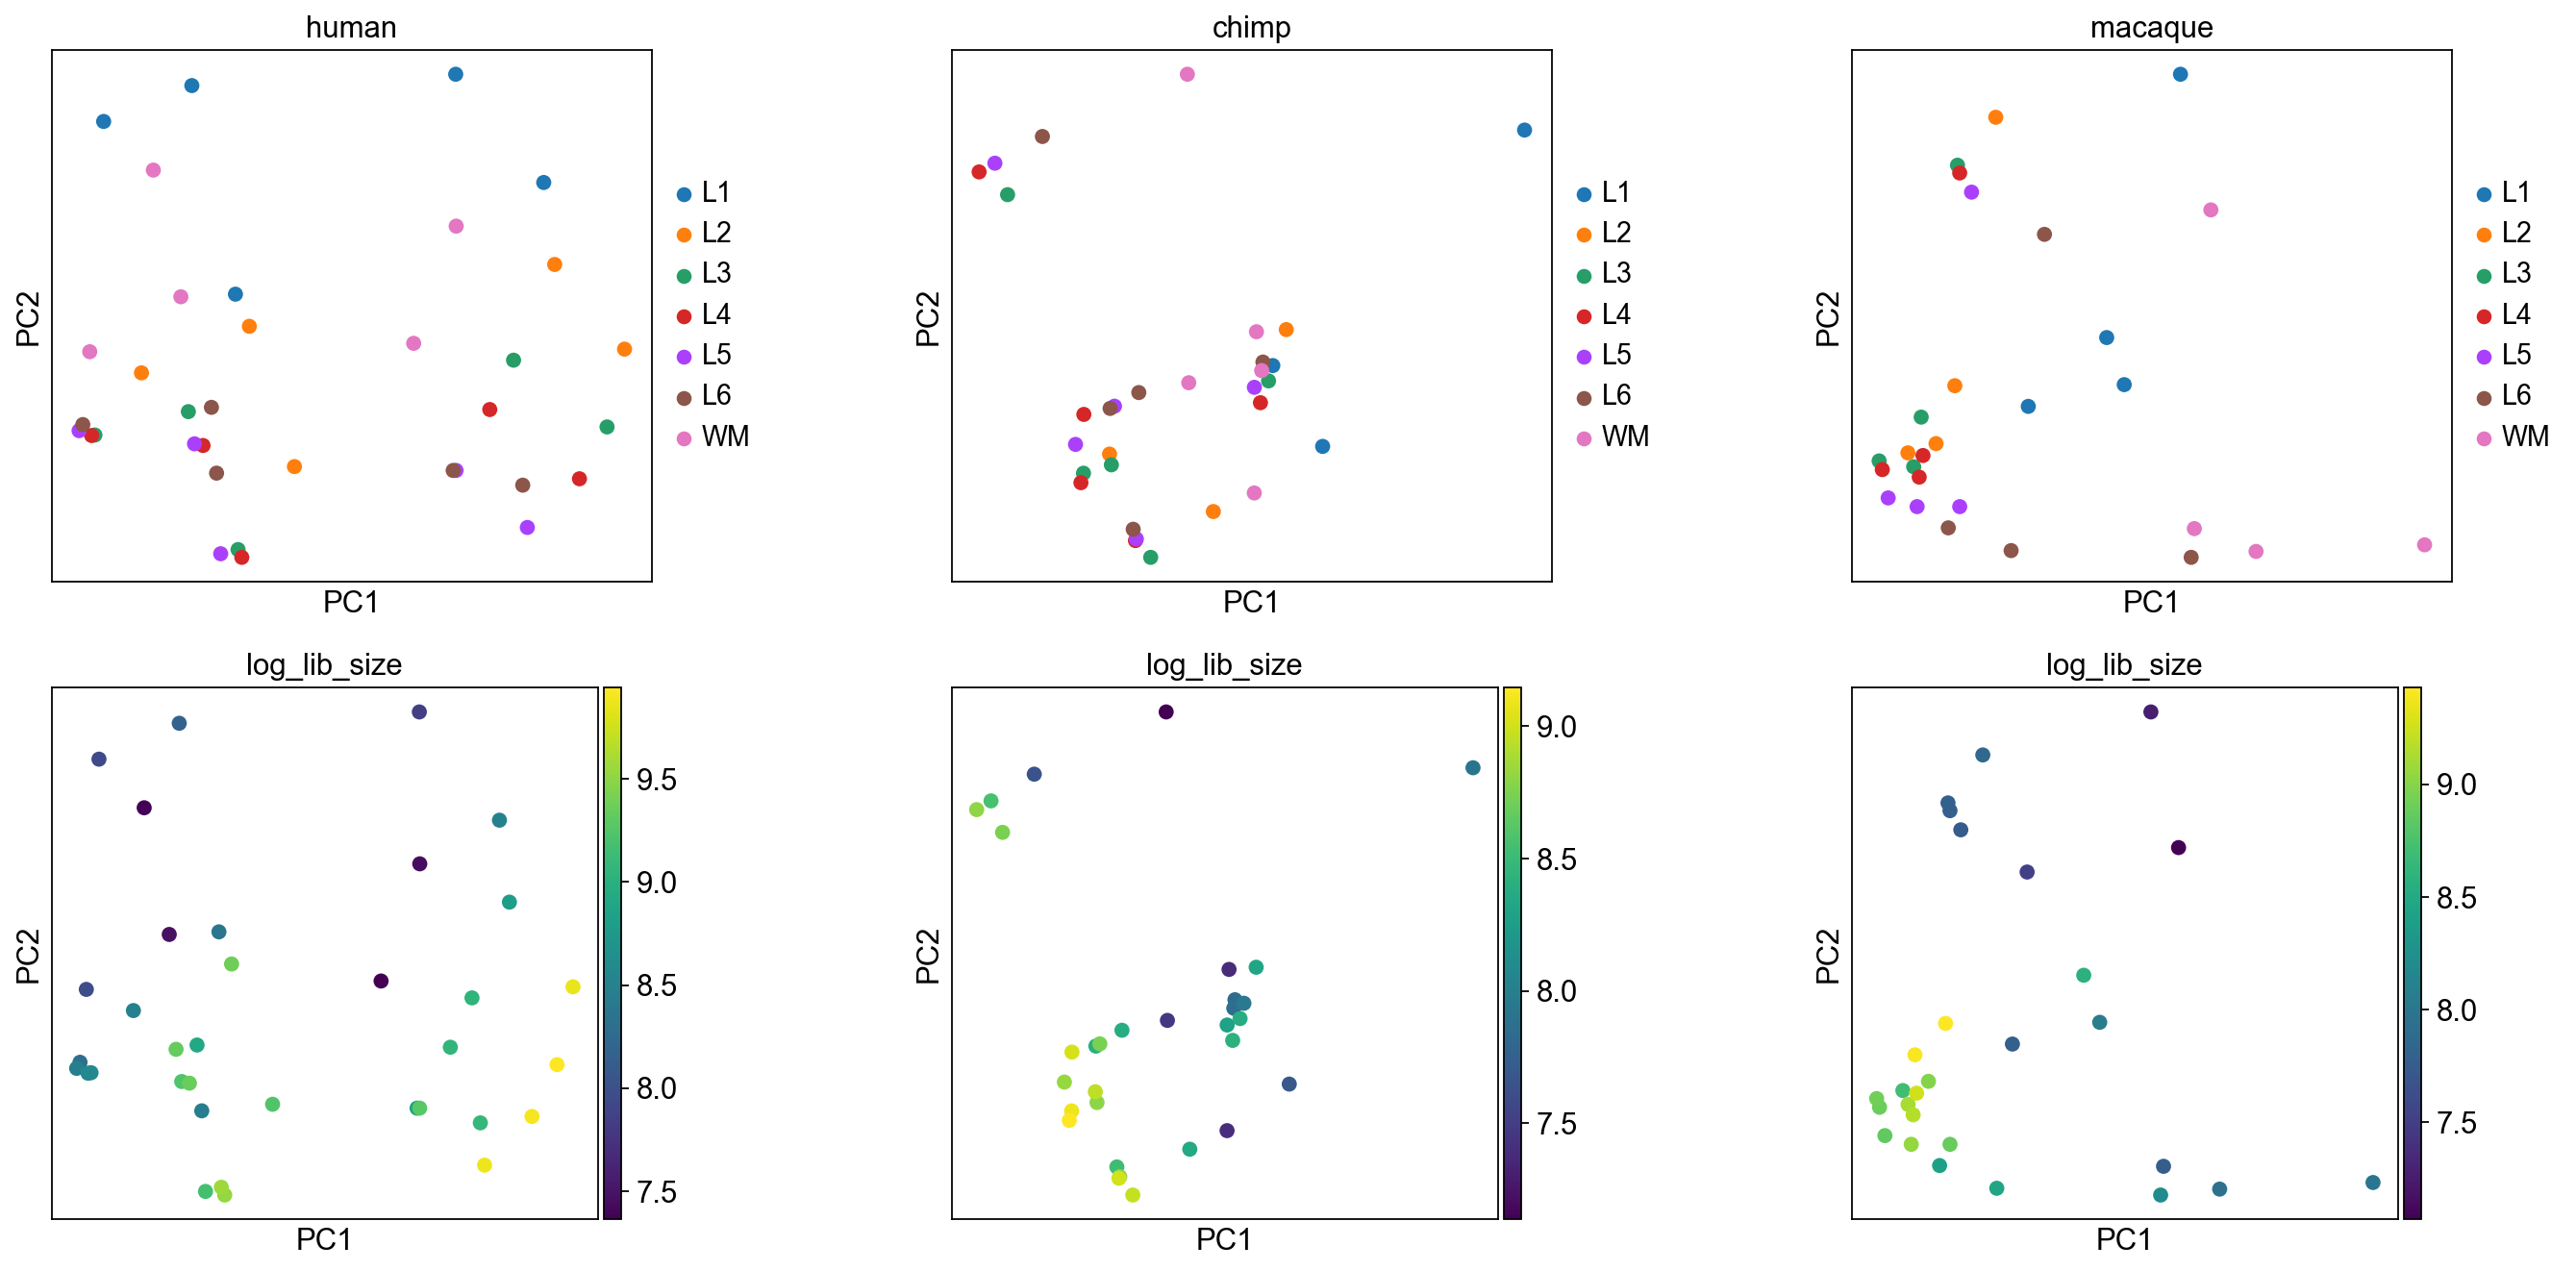

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), gridspec_kw={'wspace': 0.5})
conditions = ['human', 'chimp', 'macaque']

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = sc.read_h5ad(f'results/pb_{condition}.h5ad')
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # calculate pca
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)

## Humans (age)

In [30]:
adata_pb = sc.read_h5ad('results/pb_age.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 111 × 17919
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [31]:
# calculate library size
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["psbulk_counts"])

### Counts

Let's look at raw pseudobulks

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


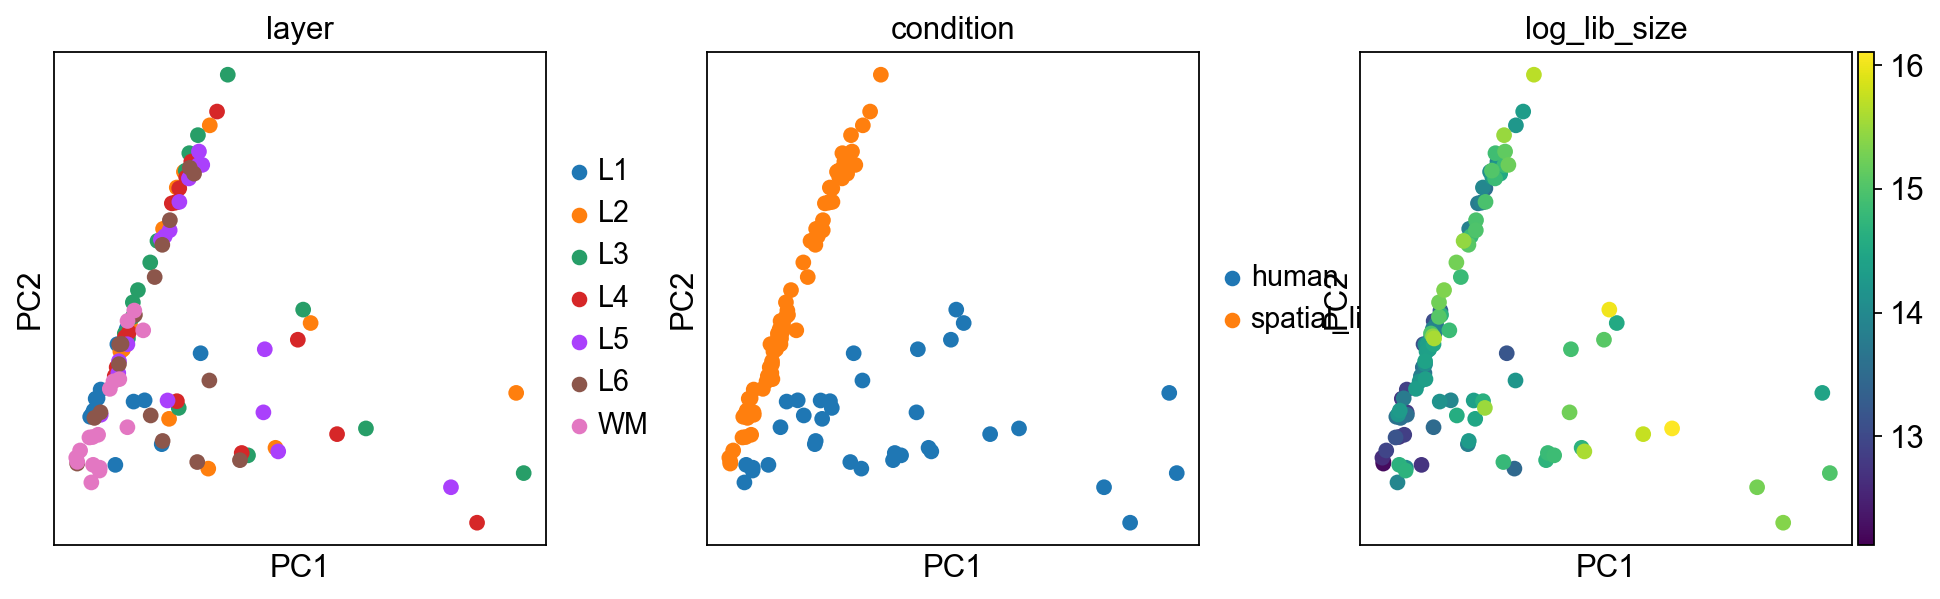

In [32]:
sc.pp.pca(adata_pb)
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/2 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)
computing PCA
    with n_comps=50


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


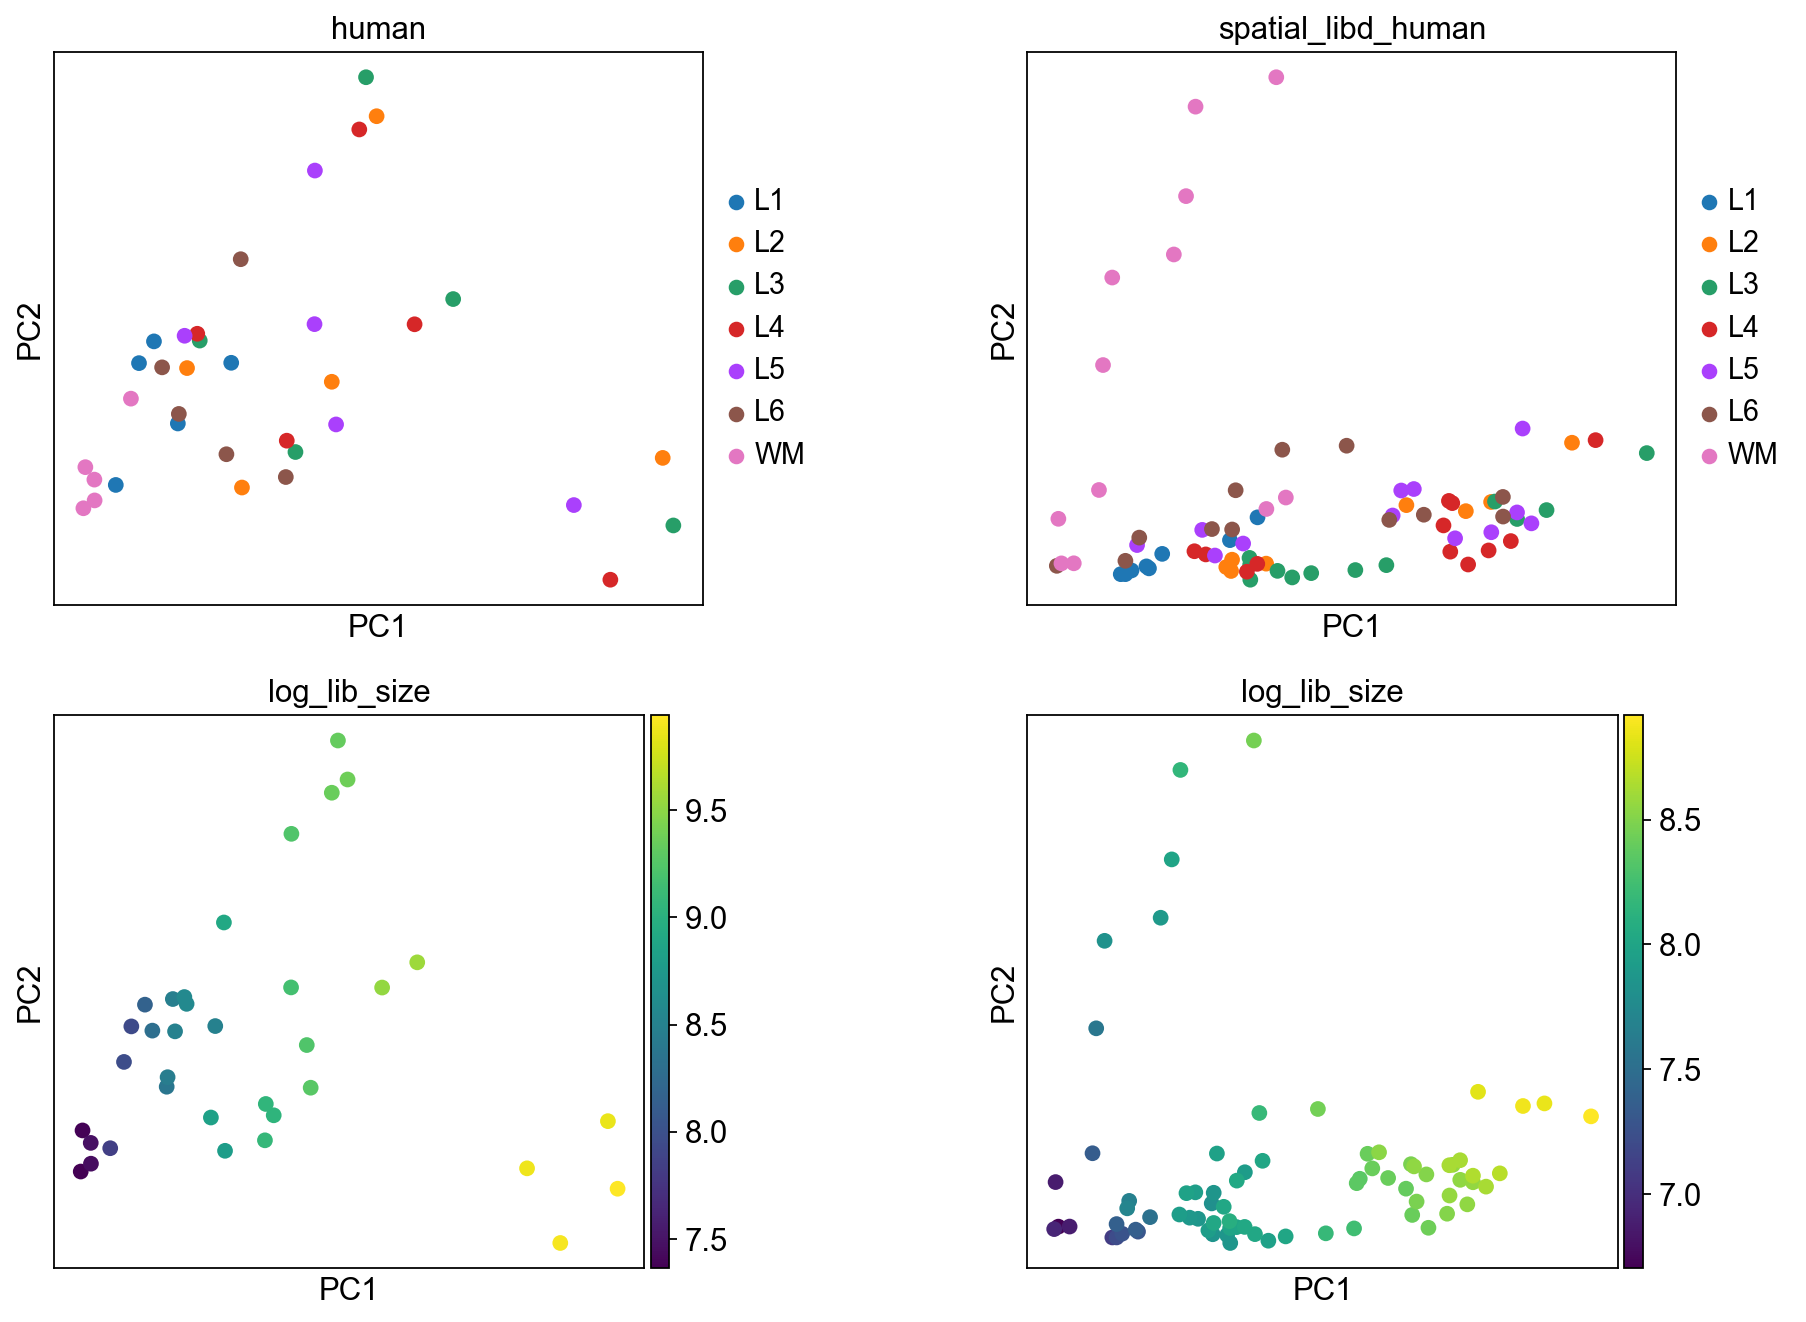

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(13, 10), gridspec_kw={'wspace': 0.5})
conditions = ['human', 'spatial_libd_human']

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = sc.read_h5ad(f'results/pb_{condition}.h5ad')
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # calculate pca
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)

### Log(CPM)

Визуализируем псевдобалки нормализованые на глубину библиотеки

In [34]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


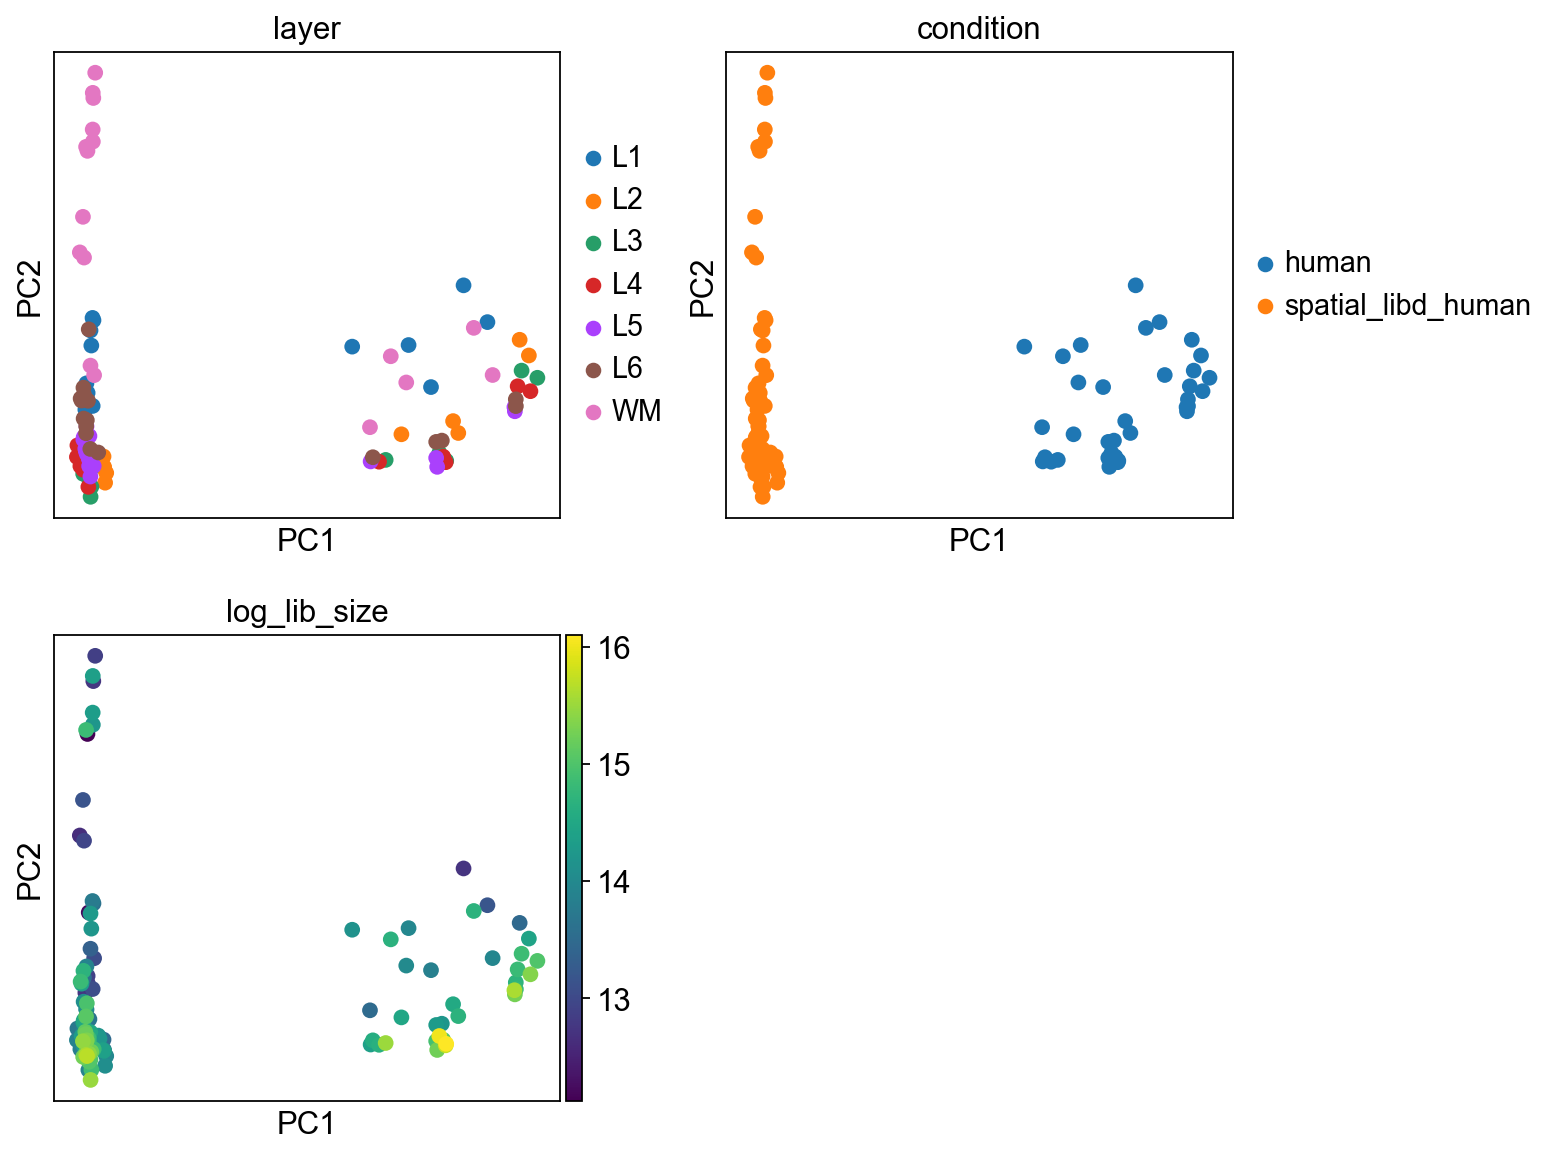

In [35]:
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=2)

  0%|          | 0/2 [00:00<?, ?it/s]

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=34
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)


d:\projects\diploma\venv_stats2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


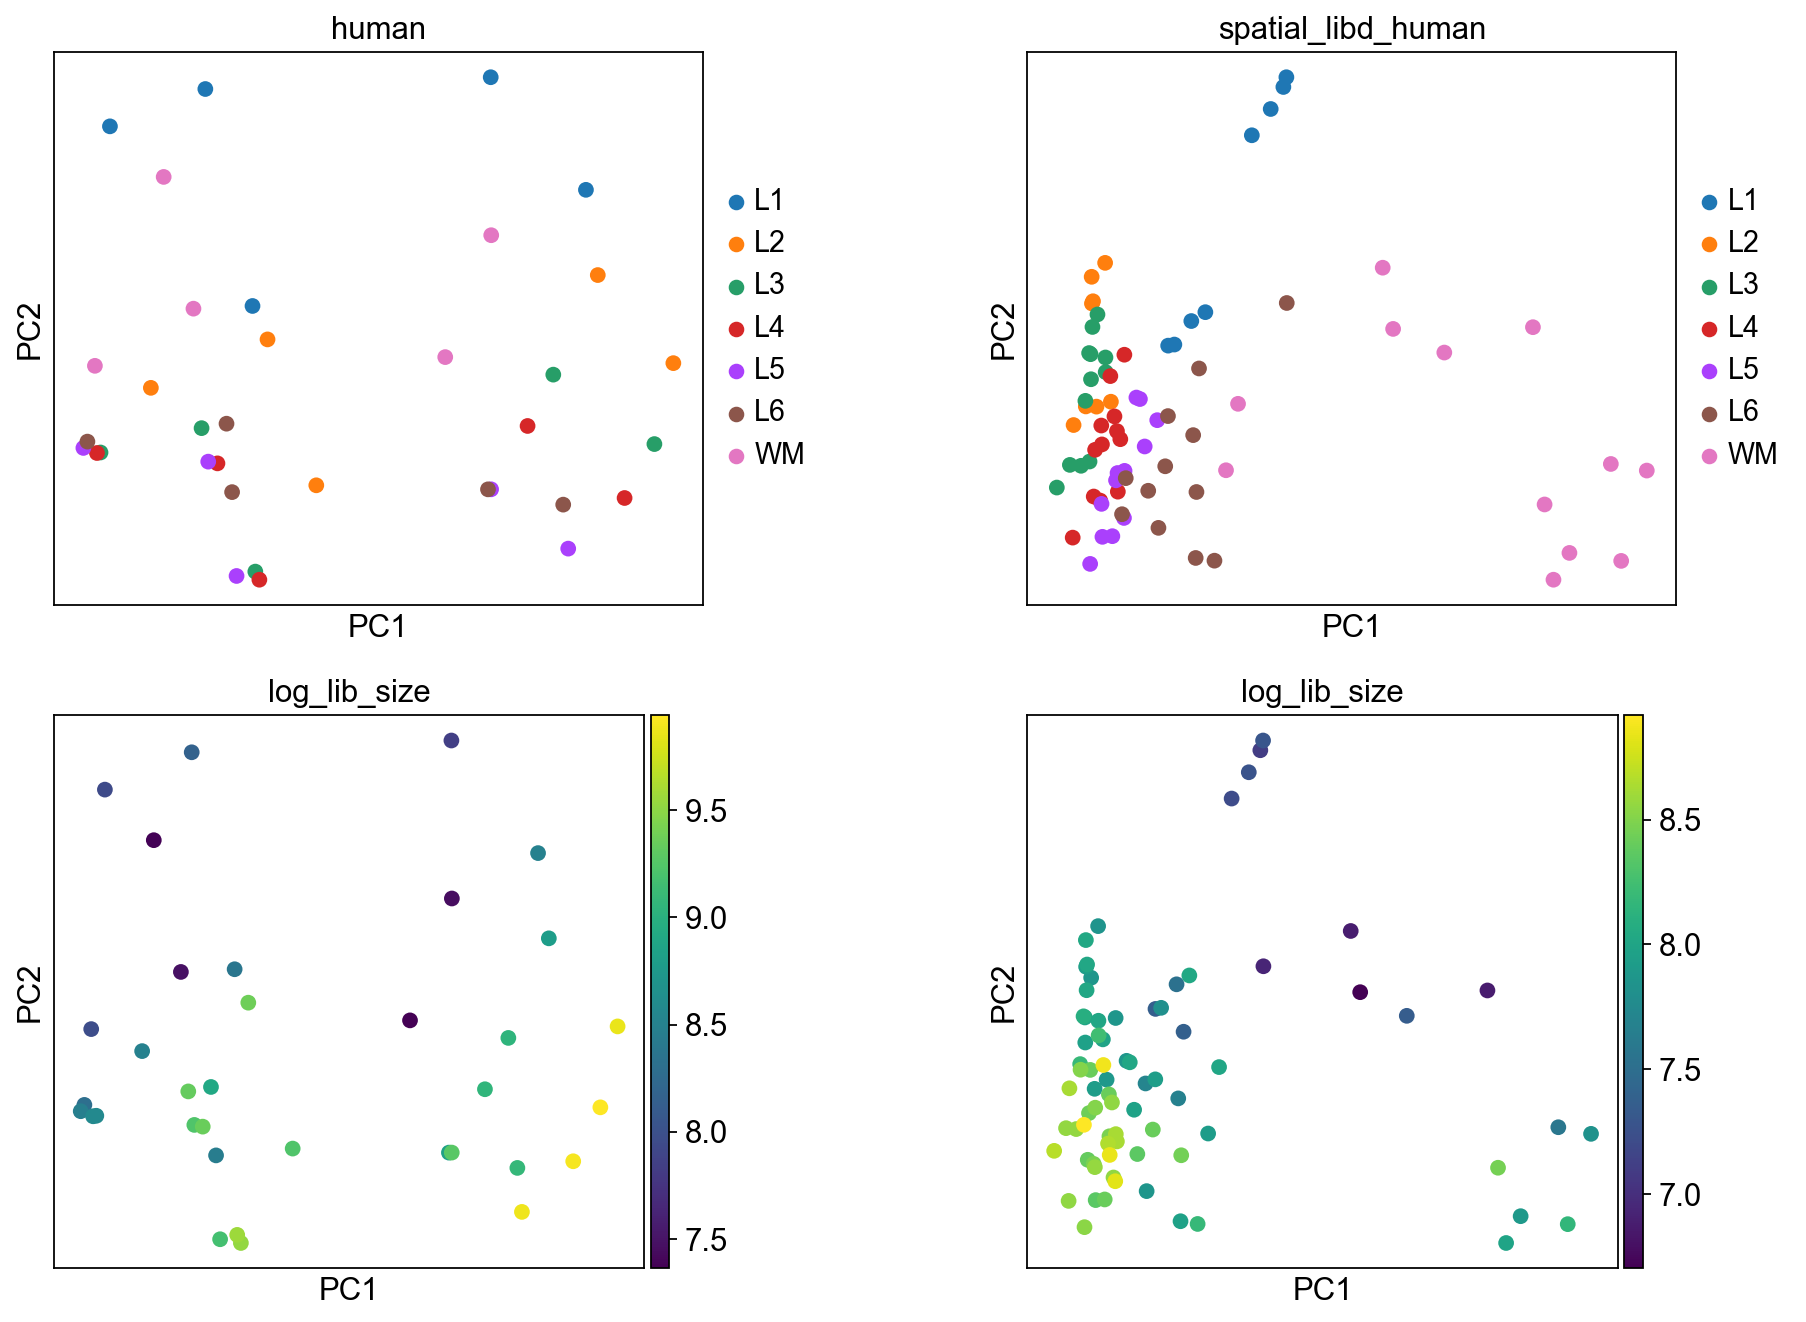

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(13, 10), gridspec_kw={'wspace': 0.5})
conditions = ['human', 'spatial_libd_human']

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = sc.read_h5ad(f'results/pb_{condition}.h5ad')
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # calculate pca
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)